In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing,model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,roc_auc_score
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_recall_fscore_support

import pickle

## Read Data

In [2]:
training = pd.read_excel("recruiting_zeta-disease_training-data_take-home-challenge (2) (1).xlsx")

In [3]:
training.tail()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
795,26,161,28.4,90,78,0.5578,42,3,0
796,37,165,33.7,60,0,0.3078,69,6,1
797,27,166,25.6,74,0,0.2638,0,5,0
798,109,139,28.1,66,94,0.2298,53,1,0
799,26,196,29.7,56,0,0.6268,0,1,0


## Data Exploration

In [4]:
training.dtypes

age                     int64
weight                  int64
bmi                   float64
blood_pressure          int64
insulin_test            int64
liver_stress_test     float64
cardio_stress_test      int64
years_smoking           int64
zeta_disease            int64
dtype: object

In [5]:
# Counts of data
print("Count: ", training.count()[0])
print("Negative Count: ", training.zeta_disease.value_counts()[0])
print("Positive Count: ", training.zeta_disease.value_counts()[1])
print("NaN values: ",sum(training.isna().sum()))
print("All zero rows: ",training[training.eq(0).all(1)].count()[0])

Count:  800
Negative Count:  521
Positive Count:  279
NaN values:  0
All zero rows:  0


<AxesSubplot:>

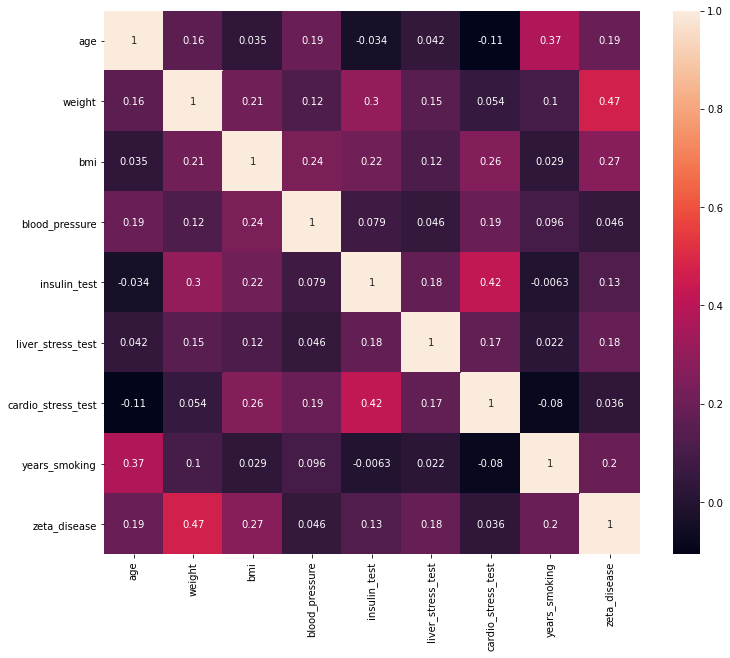

In [6]:
# Correlations of all features
plt.figure(figsize=(12,10))
sns.heatmap(training.corr(),annot=True)

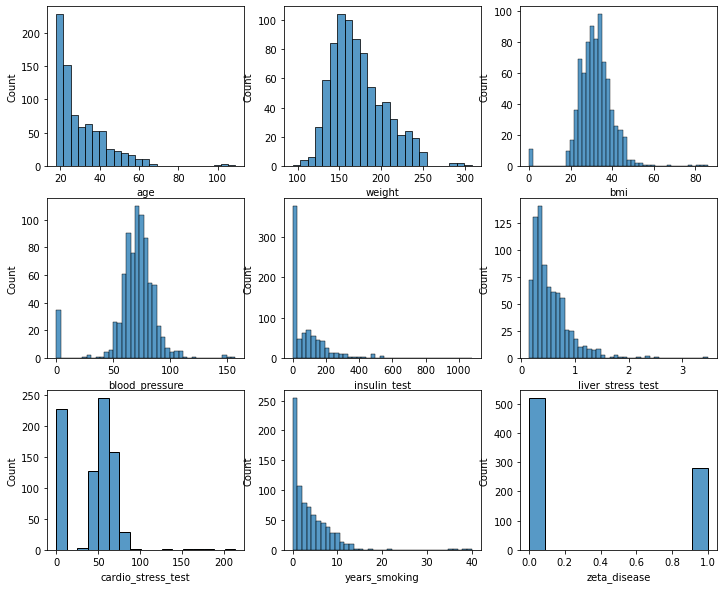

In [7]:
# Pre-cleaning distributions
plt.figure(figsize=(12,10))
for i,col in enumerate(training.columns,1):
    plt.subplot(3,3,i)
    sns.histplot(training[col])

## Data Cleaning

In [8]:
# Drop all 5 duplicates from set
training = training.drop_duplicates()
training.count()[0]

795

In [9]:
# # Assume 0 values are missing and there are no correctly 0 values for all cases


# # Impute 0's with mean
# #bmi, blood pressure, cardio stress test, insulin test

# #calculate non-zero means:
# bmi_mean = training[training['bmi']!=0]['bmi'].mean()
# bp_mean = training[training['blood_pressure']!=0]['blood_pressure'].mean()
# cst_mean = training[training['cardio_stress_test']!=0]['cardio_stress_test'].mean()
# it_mean = training[training['insulin_test']!=0]['insulin_test'].mean()

# training['bmi'].replace(0, bmi_mean, inplace=True)
# training['blood_pressure'].replace(0, bp_mean, inplace=True)
# training['cardio_stress_test'].replace(0, cst_mean, inplace=True)
# training['insulin_test'].replace(0, it_mean, inplace=True) 

In [10]:
# Impute 0's with KNN
imp = KNNImputer(missing_values=0)
fitted = pd.DataFrame(imp.fit_transform(training),columns=training.columns)

training["insulin_test"] = fitted["insulin_test"]
training["bmi"] = imp.fit_transform(training[["bmi"]]).ravel()
training["blood_pressure"] = imp.fit_transform(training[["blood_pressure"]]).ravel()
training["cardio_stress_test"] = imp.fit_transform(training[["cardio_stress_test"]]).ravel()


training = training.dropna()

In [11]:
#Cap and floor outliers
pd.options.mode.chained_assignment = None # Surpress SettingWithCopyWarning

for col in training.columns:
    quantiles = training[col].quantile([0.01,0.99]).values
    print(col, quantiles)
    training[col][training[col] >= quantiles[1]] = quantiles[1]
    training[col][training[col] <= quantiles[0]] = quantiles[0]

age [18. 66.]
weight [117.9 247. ]
bmi [19.49 53.38]
blood_pressure [ 44. 110.]
insulin_test [ 28.6 543.2]
liver_stress_test [0.1584 1.765 ]
cardio_stress_test [40.  90.3]
years_smoking [ 0. 14.]
zeta_disease [0. 1.]


In [12]:
# Binning for variables like age
# training['age'] = pd.qcut(training['age'], 10, labels=False)

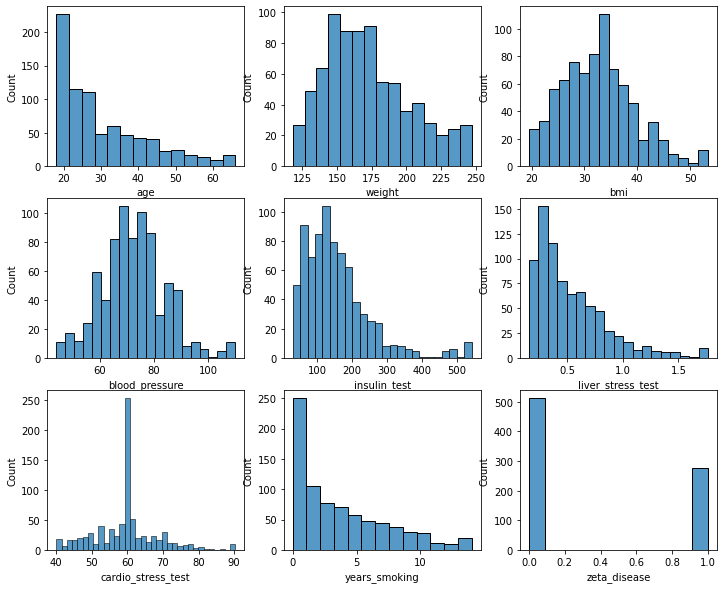

In [13]:
plt.figure(figsize=(12,10))
for i,col in enumerate(training.columns,1):
    plt.subplot(3,3,i)
    sns.histplot(training[col])

In [14]:
# Normalize numeric columns with StandardScaler 
scaler = preprocessing.StandardScaler() # Subtract mean and devide by standard deviation
training.iloc[:,:-1] = scaler.fit_transform(training.iloc[:, :-1])
training.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,1.966053,0.544998,-0.792674,0.615907,0.495727,3.017830,0.078285,1.754082,0
1,-0.620298,-0.722274,0.871101,-0.387556,-0.873415,-0.475386,-0.514850,-0.555976,0
2,1.382038,0.447516,-0.384028,1.452126,0.514257,-0.831900,0.078285,0.887810,0
3,-1.037451,-0.722274,-0.252677,-0.220312,3.987556,0.378372,-0.402475,-1.133491,0
4,-0.536867,-0.397333,-0.019165,0.114175,-0.317523,0.694232,-0.065349,-0.555976,0


In [15]:
# Split training / testing data (80%/20%)
X_train, X_test, y_train, y_test = model_selection.train_test_split(training.iloc[:,:-1], training['zeta_disease'],test_size=.2, random_state=123)
print(y_train.count())
print(y_test.count())

632
159


## Model Building

### Logistic Regression with feature elimination for Feature Importance

In [16]:
# LR
lr = RFECV(LogisticRegression(), scoring = "roc_auc", n_jobs = -1)

lr.fit(X_train, y_train)
lr_probs = lr.predict_proba(X_test)

print('AUC: ', roc_auc_score(y_test, lr_probs[:,1]))
print('Accuracy: ', lr.score(X_test, y_test), '\n')

importance = lr.estimator_.coef_
for i,v in enumerate(importance[0]):
    print(X_test.columns[i],v)

AUC:  0.8067340067340067
Accuracy:  0.7610062893081762 

age 1.208152395407111
weight 0.4924675871517541
bmi -0.18768670531454873
blood_pressure 0.27419533743010366
insulin_test 0.21701329269594594
liver_stress_test 0.3998782593886258


cardio_stress_test and years_smoking are removed from model - no impact on other models

### Support Vector Machine

In [17]:
# SVC
params = {'gamma': [1e-3, 1e-4], 
          'C': [1, 10, 100, 1000]}

svc = GridSearchCV(SVC(probability=True), params, scoring='roc_auc', n_jobs = -1)

svc.fit(X_train, y_train)
svc_probs = svc.predict_proba(X_test)

print('AUC: ', roc_auc_score(y_test, svc_probs[:,1]))
print('Accuracy: ', svc.score(X_test, y_test))

AUC:  0.8114478114478114
Accuracy:  0.8114478114478114


### Random Forest

In [18]:
# Set hyperparams and fit model
params ={'n_estimators': [x for x in range(200,2000,400)],
       'max_depth': [x for x in range(10,110,40)],
       'min_samples_split': [2,5,10],
       'min_samples_leaf': [1,2,4]}

rf = GridSearchCV(RandomForestClassifier(random_state=4321), params, scoring='roc_auc', n_jobs = -1)

rf.fit(X_train,y_train)
rf_probs = rf.predict_proba(X_test)

print('AUC: ', roc_auc_score(y_test, rf_probs[:,1]))
print('Accuracy: ', rf.score(X_test, y_test))

AUC:  0.8148148148148149
Accuracy:  0.8148148148148149


Threshold:  0.390416651696257


<AxesSubplot:>

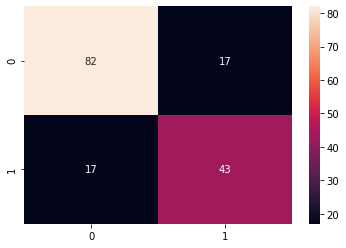

In [19]:
# Evaluate and identify threshold to maximize accuracy

fpr, tpr, thresholds = roc_curve(y_test, rf_probs[:,1])
accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(accuracy_score(y_test, rf_probs[:,1] > thresh))
    
accuracies = np.array(accuracy_scores)
max_accuracy = accuracies.max() 
max_accuracy_threshold =  thresholds[accuracies.argmax()]
print("Threshold: ", max_accuracy_threshold)

y_pred = (rf_probs[:,1] >= max_accuracy_threshold).astype('int')
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

In [20]:
metrics = precision_recall_fscore_support(y_test, y_pred, pos_label=0,average='binary')
print('Accuracy: ', rf.score(X_test, y_test))
print("Precision: ", metrics[0])
print("Recall: ", metrics[1])
print("F1: ", metrics[2])

Accuracy:  0.8148148148148149
Precision:  0.8282828282828283
Recall:  0.8282828282828283
F1:  0.8282828282828283


In [21]:
# save model
pickle.dump(rf,open('random_forest_model.sav','wb'))